## <b><i>Modelo Estatístico para previsão de </b>'Gorjetas'</i>
<b>Este conjunto de dados contém as seguintes informações:</b><br><br><i>
<b>total_bill:</b> valor total da conta.<br>
<b>tip:</b> valor da gorjeta.<br>
<b>sex:</b> sexo da pessoa que pagou a conta.<br>
<b>smoker:</b> indica se a pessoa que pagou a conta é fumante.<br>
<b>day:</b> dia da semana<br>
<b>time:</b> horário da refeição: almoço (lunch) ou jantar (dinner).<br>
<b>size:</b> indica o número de pessoas que estavam na mesa.<br>

### Importação das bibliotécas

In [337]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import shapiro, pearsonr, spearmanr, kendalltau
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_breuschpagan

### Configurações para os gráficos

In [338]:
plot_config= {
        "axes.facecolor": "#383838",    # Cor de fundo dos gráficos
        "figure.facecolor": "#383838",  # Cor de fundo da figura
        "text.color": "white",          # Cor do texto
        "axes.labelcolor": "white",     # Cor dos rótulos dos eixos
        "xtick.color": "white",         # Cor dos ticks do eixo x
        "ytick.color": "white",         # Cor dos ticks do eixo y
        "axes.edgecolor": "white",      # Cor das bordas dos gráficos
        "axes.spines.top": False,       # Ativar ou remover borda superior
        "axes.spines.right": False,     # Ativar ou remover borda direita
        "axes.grid": False,             # Ativar ou remover grade
        "grid.color": "#686868",        # Cor da grade
        "grid.linestyle": "--",         # Estilo da grade
        "figure.figsize": (10, 5)       # Tamanho padrão da figura
}
sns.set_theme(rc= plot_config)

### Carga dos dados e configuração para exibição numérica

In [339]:
df= sns.load_dataset("tips")
pd.options.display.float_format = '{:.2f}'.format

print(f"A amostra contém {df.shape[0]} registros e {df.shape[1]} variáveis\n")
df.head(3)

A amostra contém 244 registros e 7 variáveis



,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


### Quantidade de dados nulos para cada variável

In [340]:
df.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

### Criação de Variáveis
Criação da variável <b>person_bill</b> (conta dividida pela quantidade de pessoas);<br>
Criação da variável <b>person_tip</b> (gorjeta dividida pela quantidade de pessoas);<br>
Criação da variável <b>waiter_percent</b> (percentual recebido como gorjeta pelo garçon)

In [341]:
df["person_bill"] = round((df["total_bill"] / df["size"]), 2)
df["person_tip"] = round((df["tip"] / df["size"]), 2)
df["waiter_percent"] = round((df["tip"] / df["total_bill"])* 100, 2)

df.head(3)

,total_bill,tip,sex,smoker,day,time,size,person_bill,person_tip,waiter_percent
0,16.99,1.01,Female,No,Sun,Dinner,2,8.49,0.50,5.94
1,10.34,1.66,Male,No,Sun,Dinner,3,3.45,0.55,16.05
2,21.01,3.50,Male,No,Sun,Dinner,3,7.00,1.17,16.66


#### Distribuições Condicionais

In [342]:
df.groupby("sex", observed=True)[["person_bill", "person_tip", "waiter_percent"]].mean()

,person_bill,person_tip,waiter_percent
sex,,,
Male,8.12,1.22,15.76
Female,7.46,1.19,16.65


In [343]:
df.groupby("smoker", observed=True)[["person_bill", "person_tip", "waiter_percent"]].mean()

,person_bill,person_tip,waiter_percent
smoker,,,
Yes,8.74,1.30,16.32
No,7.36,1.16,15.93


### Tipo dos dados

In [344]:
df.dtypes

total_bill         float64
tip                float64
sex               category
smoker            category
day               category
time              category
size                 int64
person_bill        float64
person_tip         float64
waiter_percent     float64
dtype: object

### Analise descritiva das medidas de tendencia central

In [345]:
numericas = df.select_dtypes(include='number')
numericas.describe()

,total_bill,tip,size,person_bill,person_tip,waiter_percent
count,244.00,244.00,244.00,244.00,244.00,244.00
mean,19.79,3.00,2.57,7.89,1.21,16.08
std,8.90,1.38,0.95,2.91,0.49,6.11
min,3.07,1.00,1.00,2.88,0.40,3.56
25%,13.35,2.00,2.00,5.80,0.86,12.91
50%,17.80,2.90,2.00,7.25,1.11,15.47
75%,24.13,3.56,3.00,9.39,1.50,19.15
max,50.81,10.00,6.00,20.27,3.33,71.03


### Visualização para análise de outliers

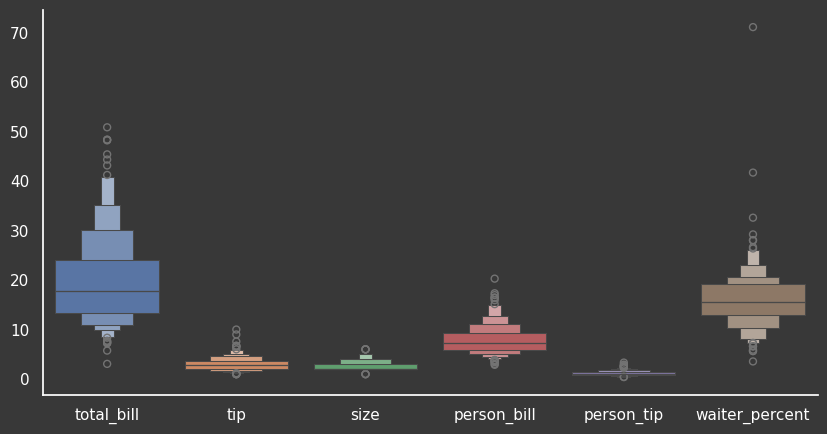

In [346]:
sns.boxenplot(numericas);

### Verificação de dados únicos por variável categórica

In [347]:
categoricas = df.select_dtypes(include="category")
for i in categoricas.columns:
  print(f"Dados únicos da variável '{i}':\n{categoricas[i].unique()}\n")

Dados únicos da variável 'sex':
['Female', 'Male']
Categories (2, object): ['Male', 'Female']

Dados únicos da variável 'smoker':
['No', 'Yes']
Categories (2, object): ['Yes', 'No']

Dados únicos da variável 'day':
['Sun', 'Sat', 'Thur', 'Fri']
Categories (4, object): ['Thur', 'Fri', 'Sat', 'Sun']

Dados únicos da variável 'time':
['Dinner', 'Lunch']
Categories (2, object): ['Lunch', 'Dinner']



### Transformação das Variáveis Categóricas
#### LabelEncoder

In [348]:
df["sex_encoded"] = np.where(df["sex"] == "Female", 1, 0)

df.drop("sex", axis=1, inplace=True)
df.head()

,total_bill,tip,smoker,day,time,size,person_bill,person_tip,waiter_percent,sex_encoded
0,16.99,1.01,No,Sun,Dinner,2,8.49,0.50,5.94,1
1,10.34,1.66,No,Sun,Dinner,3,3.45,0.55,16.05,0
2,21.01,3.50,No,Sun,Dinner,3,7.00,1.17,16.66,0
3,23.68,3.31,No,Sun,Dinner,2,11.84,1.66,13.98,0
4,24.59,3.61,No,Sun,Dinner,4,6.15,0.90,14.68,1


In [349]:
#le = LabelEncoder()
#for i in ["sex"]:
#  df[i] = le.fit_transform(df[i])
#df.head()

#### One-Hot Encoding

In [350]:
df = pd.get_dummies(data=df, columns=["smoker", "time"], dtype=int)
df.head(3)

,total_bill,tip,day,size,person_bill,person_tip,waiter_percent,sex_encoded,smoker_Yes,smoker_No,time_Lunch,time_Dinner
0,16.99,1.01,Sun,2,8.49,0.50,5.94,1,0,1,0,1
1,10.34,1.66,Sun,3,3.45,0.55,16.05,0,0,1,0,1
2,21.01,3.50,Sun,3,7.00,1.17,16.66,0,0,1,0,1


### Target Encoding com Smoothing

Misturar a média da categoria com a média global, de forma ponderada pelo número de ocorrências da categoria.

**Fórmula comum:**

$$
Encoding(c) = \frac{n_c \cdot \mu_c + m \cdot \mu}{n_c + m}
$$

Onde:  
- $\mu_c$ = média do target na categoria \(c\)  
- $n_c$ = quantidade de registros na categoria \(c\)  
- $\mu$ = média global do target  
- $m$ = parâmetro de suavização (quanto maior, mais peso à média global)  

**Observações:**
- Smoothing resolve instabilidade (poucos dados por categoria).
- É necessário separar treino/teste antes de aplicar para não ocorrer vazamento de dados.

In [351]:
# Média global
global_mean = df["tip"].mean()
# Contagem e média por categoria
agg = df.groupby("day", observed=True)["tip"].agg(["mean", "count"])
# Parâmetro de suavização
m = 5
# Fórmula do smoothing
agg["smoothed"] = (agg["count"] * agg["mean"] + m * global_mean) / (agg["count"] + m)
# Mapear para o dataset
df["day_encoded"] = df["day"].map(agg["smoothed"])

df.drop("day", axis=1, inplace=True)
df["day_encoded"].unique()

[3.24, 2.99, 2.79, 2.79]
Categories (4, float64): [2.79, 2.79, 2.99, 3.24]

### Teste de normalidade das variáveis.
Um valor de p <= 0.05 rejeitamos a hipótese nula,<br>
ou seja, os dados não possuem distribuição normal.

In [352]:
print("Teste de Normalidade (Shapiro-Wilk):\n")
for col in numericas.columns:
  stat, p = shapiro(numericas[col])
  print(f"{col}: stat= {stat:.4f}, p= {p:.4f}")

Teste de Normalidade (Shapiro-Wilk):

total_bill: stat= 0.9197, p= 0.0000
tip: stat= 0.8978, p= 0.0000
size: stat= 0.7120, p= 0.0000
person_bill: stat= 0.9218, p= 0.0000
person_tip: stat= 0.9314, p= 0.0000
waiter_percent: stat= 0.7994, p= 0.0000


#### Correlação de Pearson
O **Coeficiente de Correlação de Pearson** mede a **força** e a **direção** da relação linear entre duas variáveis quantitativas. Ele assume que as variáveis têm uma distribuição normal.

- **Quando usar**: Pearson é utilizado quando as variáveis têm uma relação linear e ambas seguem uma **distribuição normal**.

Onde $ r $ varia entre -1 e 1:
  - $ r = 1 $: Correlação positiva perfeita
  - $ r = -1 $: Correlação negativa perfeita
  - $ r = 0 $: Sem correlação linear

In [353]:
corr_pearson = df.corr(method="pearson")
corr_pearson

,total_bill,tip,size,person_bill,person_tip,waiter_percent,sex_encoded,smoker_Yes,smoker_No,time_Lunch,time_Dinner,day_encoded
total_bill,1.00,0.68,0.60,0.65,0.24,-0.34,-0.14,0.09,-0.09,-0.18,0.18,0.17
tip,0.68,1.00,0.49,0.35,0.68,0.34,-0.09,0.01,-0.01,-0.12,0.12,0.14
size,0.60,0.49,1.00,-0.18,-0.25,-0.14,-0.09,-0.13,0.13,-0.10,0.10,0.20
person_bill,0.65,0.35,-0.18,1.00,0.54,-0.31,-0.11,0.23,-0.23,-0.12,0.12,0.04
person_tip,0.24,0.68,-0.25,0.54,1.00,0.53,-0.03,0.14,-0.14,-0.04,0.04,0.00
waiter_percent,-0.34,0.34,-0.14,-0.31,0.53,1.00,0.07,0.03,-0.03,0.03,-0.03,0.03
sex_encoded,-0.14,-0.09,-0.09,-0.11,-0.03,0.07,1.00,-0.00,0.00,0.21,-0.21,-0.22
smoker_Yes,0.09,0.01,-0.13,0.23,0.14,0.03,-0.00,1.00,-1.00,-0.05,0.05,-0.12
smoker_No,-0.09,-0.01,0.13,-0.23,-0.14,-0.03,0.00,-1.00,1.00,0.05,-0.05,0.12
time_Lunch,-0.18,-0.12,-0.10,-0.12,-0.04,0.03,0.21,-0.05,0.05,1.00,-1.00,-0.73


#### Correlação de Spearman
O **Coeficiente de Spearman** mede a relação **monotônica** entre duas variáveis, o que significa que, à medida que uma variável aumenta, a outra também aumenta ou diminui, mas não necessariamente de forma linear.

- **Quando usar**: Use Spearman quando os dados não forem normalmente distribuídos ou se a relação entre as variáveis for **monotônica** (não linear).
- Baseia-se no ranking das variáveis.

In [354]:
corr_spearman = df.corr(method='spearman')
corr_spearman

,total_bill,tip,size,person_bill,person_tip,waiter_percent,sex_encoded,smoker_Yes,smoker_No,time_Lunch,time_Dinner,day_encoded
total_bill,1.00,0.68,0.60,0.63,0.27,-0.32,-0.15,0.06,-0.06,-0.21,0.21,0.20
tip,0.68,1.00,0.47,0.40,0.70,0.40,-0.06,0.02,-0.02,-0.14,0.14,0.18
size,0.60,0.47,1.00,-0.18,-0.26,-0.15,-0.10,-0.13,0.13,-0.16,0.16,0.24
person_bill,0.63,0.40,-0.18,1.00,0.61,-0.24,-0.09,0.17,-0.17,-0.11,0.11,0.02
person_tip,0.27,0.70,-0.26,0.61,1.00,0.55,0.01,0.11,-0.11,-0.04,0.04,0.02
waiter_percent,-0.32,0.40,-0.15,-0.24,0.55,1.00,0.10,-0.04,0.04,0.08,-0.08,-0.03
sex_encoded,-0.15,-0.06,-0.10,-0.09,0.01,0.10,1.00,-0.00,0.00,0.21,-0.21,-0.23
smoker_Yes,0.06,0.02,-0.13,0.17,0.11,-0.04,-0.00,1.00,-1.00,-0.05,0.05,-0.08
smoker_No,-0.06,-0.02,0.13,-0.17,-0.11,0.04,0.00,-1.00,1.00,0.05,-0.05,0.08
time_Lunch,-0.21,-0.14,-0.16,-0.11,-0.04,0.08,0.21,-0.05,0.05,1.00,-1.00,-0.80


#### Correlação de Kendall
O **Coeficiente de Kendall** é outra medida não paramétrica que mede a associação entre duas variáveis. Ele leva em consideração a concordância entre pares de observações.

- **Quando usar**: Utilize Kendall quando o número de dados é pequeno, ou quando há muitos empates nos dados.
- Baseia-se na concordância e discordância de pares ordenados.

In [355]:
corr_kendall = df.corr(method='kendall')
corr_kendall

,total_bill,tip,size,person_bill,person_tip,waiter_percent,sex_encoded,smoker_Yes,smoker_No,time_Lunch,time_Dinner,day_encoded
total_bill,1.00,0.52,0.48,0.54,0.19,-0.22,-0.12,0.05,-0.05,-0.17,0.17,0.15
tip,0.52,1.00,0.38,0.28,0.58,0.28,-0.05,0.01,-0.01,-0.12,0.12,0.14
size,0.48,0.38,1.00,-0.14,-0.21,-0.12,-0.09,-0.12,0.12,-0.16,0.16,0.21
person_bill,0.54,0.28,-0.14,1.00,0.45,-0.17,-0.07,0.14,-0.14,-0.09,0.09,0.02
person_tip,0.19,0.58,-0.21,0.45,1.00,0.40,0.01,0.09,-0.09,-0.03,0.03,0.02
waiter_percent,-0.22,0.28,-0.12,-0.17,0.40,1.00,0.08,-0.03,0.03,0.06,-0.06,-0.02
sex_encoded,-0.12,-0.05,-0.09,-0.07,0.01,0.08,1.00,-0.00,0.00,0.21,-0.21,-0.21
smoker_Yes,0.05,0.01,-0.12,0.14,0.09,-0.03,-0.00,1.00,-1.00,-0.05,0.05,-0.07
smoker_No,-0.05,-0.01,0.12,-0.14,-0.09,0.03,0.00,-1.00,1.00,0.05,-0.05,0.07
time_Lunch,-0.17,-0.12,-0.16,-0.09,-0.03,0.06,0.21,-0.05,0.05,1.00,-1.00,-0.75


### Teste de Hipótese para Correlação entre total_bill e tip

- H0: rho = 0 (sem correlação)
- H1: rho ≠ 0

In [356]:
print("\nTeste de Hipótese - Correlação entre total_bill e tip")

r, p_valor = pearsonr(df["total_bill"], df["tip"])
print(f"Pearson r = {r:.4f}, p = {p_valor:.4f}")

r, p_valor = spearmanr(df["total_bill"], df["tip"])
print(f"Spearman r = {r:.4f}, p = {p_valor:.4f}")

r, p_valor = kendalltau(df["total_bill"], df["tip"])
print(f"Kendall tau = {r:.4f}, p = {p_valor:.4f}")

print("\nUm p-valor <= 0,05 indica uma Correlação significativa")


Teste de Hipótese - Correlação entre total_bill e tip
Pearson r = 0.6757, p = 0.0000
Spearman r = 0.6790, p = 0.0000
Kendall tau = 0.5172, p = 0.0000

Um p-valor <= 0,05 indica uma Correlação significativa


#### Visualização para Correlação entre 'total_bill' e 'tip'

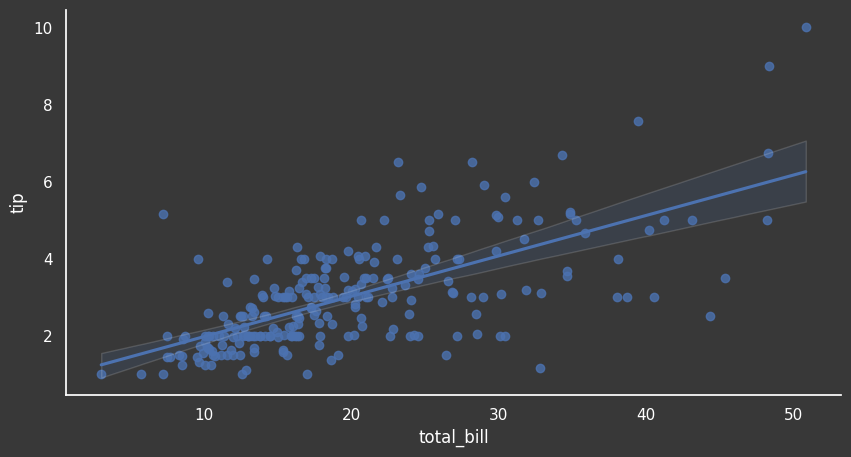

In [357]:
sns.regplot(data= df, x= "total_bill", y= "tip");

### Ausência de Multicolinearidade
Correlação das variáveis independentes

In [358]:
independentes = df[["total_bill", "size"]]
independentes.corr()

,total_bill,size
total_bill,1.00,0.60
size,0.60,1.00


### Escalonamento
#### Padronização dos Dados
Padronização é o processo de centralizar as variáveis em torno da média e escalá-las para ter desvio padrão 1.

In [359]:
scaler = StandardScaler()
padronizadas = scaler.fit_transform(df)
padronizadas = pd.DataFrame(padronizadas, columns=df.columns)
padronizadas.head(3)

,total_bill,tip,size,person_bill,person_tip,waiter_percent,sex_encoded,smoker_Yes,smoker_No,time_Lunch,time_Dinner,day_encoded
0,-0.31,-1.44,-0.60,0.21,-1.45,-1.66,1.34,-0.78,0.78,-0.62,0.62,1.31
1,-1.06,-0.97,0.45,-1.53,-1.35,-0.00,-0.74,-0.78,0.78,-0.62,0.62,1.31
2,0.14,0.36,0.45,-0.31,-0.09,0.10,-0.74,-0.78,0.78,-0.62,0.62,1.31


#### Normalização Min-Max
A normalização Min-Max escala as variáveis para um intervalo específico, geralmente [0, 1], útil para algoritmos sensíveis à escala dos dados

In [360]:
minmax = MinMaxScaler()
normalizadas = minmax.fit_transform(df)
normalizadas = pd.DataFrame(normalizadas, columns=df.columns)
normalizadas.head(3)

,total_bill,tip,size,person_bill,person_tip,waiter_percent,sex_encoded,smoker_Yes,smoker_No,time_Lunch,time_Dinner,day_encoded
0,0.29,0.00,0.20,0.32,0.03,0.04,1.00,0.00,1.00,0.00,1.00,1.00
1,0.15,0.07,0.40,0.03,0.05,0.19,0.00,0.00,1.00,0.00,1.00,1.00
2,0.38,0.28,0.40,0.24,0.26,0.19,0.00,0.00,1.00,0.00,1.00,1.00


### Divisão da base - Treino e Teste

In [361]:
X = padronizadas.drop(["tip", "person_tip", "waiter_percent"], axis=1)
y = padronizadas["tip"]

# Separa os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

### Seleção de Variáveis
#### Stepwise com AIC
**Teoria:**
**Stepwise Selection** é uma técnica que combina forward e backward selection, usando métricas como AIC.
- AIC penaliza modelos complexos.
- Permite encontrar subconjuntos de variáveis com bom poder preditivo sem overfitting.

In [362]:
def calculate_aic(model, X, y):
    n = len(y)
    k = X.shape[1] + 1  # número de parâmetros, incluindo o intercepto
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    aic = n * np.log(mse) + 2 * k
    return aic

#### Implementação Stepwise Forward + Backward
Iremos criar as seguintes variáveis:

- selected_features: Lista que armazenará as variáveis selecionadas durante o procedimento.
- stepwise_model: Modelo de regressão linear a ser ajustado.
- best_aic: Variável que armazenará o menor AIC encontrado.

#### Seleção de variáveis com Stepwise (avançando e removendo as variáveis com base no menor AIC)

In [363]:
def forward_backward_stepwise_selection(X, y):
    selected = []
    best_aic = float('inf')
    model = LinearRegression()

    while True:
        changed = False
        candidates = [col for col in X.columns if col not in selected]
        best_candidate, best_model = None, None

        for feat in candidates:
            model.fit(X[selected + [feat]], y)
            aic = calculate_aic(model, X[selected + [feat]], y)
            if aic < best_aic:
                best_aic, best_candidate = aic, feat
                changed = True

        if changed:
            selected.append(best_candidate)
        else:
            break

    return selected

# Retorna lista de variáveis selecionadas pelo critério de AIC
selected_stepwise = forward_backward_stepwise_selection(X_train, y_train)
print("Selecionadas pelo Stepwise:", selected_stepwise)

Selecionadas pelo Stepwise: ['total_bill', 'person_bill']


### Treinando modelo com variáveis selecionadas

Ajuste do modelo Linear com as variáveis escolhidas

In [364]:
model_stepwise = LinearRegression().fit(X_train[selected_stepwise], y_train)
y_pred_stepwise = model_stepwise.predict(X_test[selected_stepwise])

#### Avaliação do modelo Stepwise

Calcular as métricas de avaliação para o modelo Stepwise

In [365]:
n = len(y_test)
k = len(selected_stepwise)
mse = mean_squared_error(y_test, y_pred_stepwise)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results = [{
    'Modelo': 'Stepwise',
    'MAE': mean_absolute_error(y_test, y_pred_stepwise),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': model_stepwise.score(X_test[selected_stepwise], y_test)
}]

pd.DataFrame(results)

,Modelo,MAE,MSE,AIC,BIC,R²
0,Stepwise,0.50,0.36,-46.64,-42.86,0.46


### SFS (Sequential Feature Selector)

O **SFS (mlxtend)** realiza seleção de variáveis de forma sequencial:
- `forward=True`: começa com nenhuma variável e vai adicionando.
- `floating=True`: permite remoção/backward no meio do processo.
- Permite validação cruzada com métrica personalizada (ex: MSE).

In [366]:
sfs_model = SFS(LinearRegression(),
                k_features='best',
                forward=True,
                floating=True,  # Ativa stepwise (entra e remove variáveis)
                scoring='neg_mean_squared_error',
                cv=5)

sfs_model.fit(X_train, y_train)
print("Variáveis selecionadas pelo SFS:", list(sfs_model.k_feature_names_))

Variáveis selecionadas pelo SFS: ['total_bill', 'smoker_No']


#### Avaliação do modelo SFS

In [367]:
selected_sfs = list(sfs_model.k_feature_names_)
model_sfs = LinearRegression().fit(X_train[selected_sfs], y_train)
y_pred_sfs = model_sfs.predict(X_test[selected_sfs])

n = len(y_test)
k = len(selected_sfs)
mse = mean_squared_error(y_test, y_pred_sfs)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results.append({
    'Modelo': 'SFS (mlxtend)',
    'MAE': mean_absolute_error(y_test, y_pred_sfs),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': model_sfs.score(X_test[selected_sfs], y_test)
})

pd.DataFrame(results)

,Modelo,MAE,MSE,AIC,BIC,R²
0,Stepwise,0.50,0.36,-46.64,-42.86,0.46
1,SFS (mlxtend),0.46,0.33,-50.30,-46.51,0.50


### Lasso (L1 Regularization)

O **Lasso** aplica uma penalização  L1 que força alguns coeficientes a serem zero:
- Elimina variáveis irrelevantes automaticamente.
- Útil quando há muitas variáveis correlacionadas.
- O parâmetro alpha controla a intensidade da penalização.

In [368]:
alphas = np.logspace(-4, 4, 100)
lasso_cv = GridSearchCV(Lasso(), {'alpha': alphas}, cv=5)
lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.best_params_['alpha']

# Modelo final com o melhor alpha encontrado
lasso_final = Lasso(alpha=best_alpha).fit(X_train, y_train)

# Coeficientes diferentes de zero indicam variáveis selecionadas
lasso_coef = lasso_final.coef_
selected_lasso = X.columns[lasso_coef != 0]
print("Selecionadas pelo Lasso:", list(selected_lasso))

Selecionadas pelo Lasso: ['total_bill', 'size']


In [369]:
y_pred_lasso = lasso_final.predict(X_test)

n = len(y_test)
k = len(selected_lasso)
mse = mean_squared_error(y_test, y_pred_lasso)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results.append({
    'Modelo': 'Lasso',
    'MAE': mean_absolute_error(y_test, y_pred_lasso),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': lasso_final.score(X_test, y_test)
})

### Comparando os modelos

In [370]:
results_df = pd.DataFrame(results)
print(results_df)

          Modelo  MAE  MSE    AIC    BIC   R²
0       Stepwise 0.50 0.36 -46.64 -42.86 0.46
1  SFS (mlxtend) 0.46 0.33 -50.30 -46.51 0.50
2          Lasso 0.47 0.32 -52.17 -48.39 0.52


### Conclusões Didáticas
- **Stepwise**: bom ponto de partida, mas pode gerar overfitting.
- **Lasso**: ótimo para regularização e eliminar colinearidade.
- **SFS**: flexível e robusto com validação cruzada, porém mais lento.

### Uso do OLS para os Modelos

In [371]:
# Definindo as variáveis independentes usadas nos modelos anteriores
X_sfs = X[selected_sfs]
X_lasso = X[list(selected_lasso)]
# Adicionando uma constante às variaveis independentes
X_sfs = sm.add_constant(X_sfs)
X_lasso = sm.add_constant(X_lasso)
# Ajustando o modelo de regressão linear
modelo_sfs = sm.OLS(y, X_sfs).fit()
modelo_lasso = sm.OLS(y, X_lasso).fit()
# Sumário do modelo
modelo_sfs_summary = modelo_sfs.summary()
modelo_lasso_summary = modelo_lasso.summary()

# sm.OLS() é usado para ajustar o modelo de regressão linear ordinária.
# sm.add_constant() é necessário pois o OLS não adiciona automaticamente a constante (intercepto).

### Teste de Homocedasticidade (Breusch-Pagan):
Se o p-valor do teste menor que 0.05, indica a presença de heterocedasticidade e pode ser necessário ajustar o modelo ou usar métodos robustos para estimativa de variância.

In [372]:
# Calcula os resíduos do modelo
# Criação de uma lista de tuplas com os modelos e seus respectivos nomes
modelos = [
    ("modelo_sfs", modelo_sfs, X[selected_sfs]),
    ("modelo_lasso", modelo_lasso, X[list(selected_lasso)])
]

for nome, modelo,dados in modelos:
    estatistica, p, f, fp = het_breuschpagan(modelo.resid, modelo.model.exog)
    print(f'Estatísticas de teste para {nome}: {format(estatistica)}')
    print(f'p-valor: {p}')
    print(f'f-valor: {fp}')
    print(f'f_p-valor: {f}')

Estatísticas de teste para modelo_sfs: 51.44212957469795
p-valor: 6.752793887990812e-12
f-valor: 4.0659260366924635e-13
f_p-valor: 32.19175928805134
Estatísticas de teste para modelo_lasso: 48.15200992135925
p-valor: 3.498838520920026e-11
f-valor: 3.131697116564497e-12
f_p-valor: 29.626636419367546


### Teste de Normalidade dos Resíduos com Shapiro-Wilk
Se p-valor do shapiro é superior a 0.05,isso indica que os resíduos seguem aproximadamente uma distribuição normal.

In [373]:
for nome, modelo,dados in modelos:
    estatistica_shapiro,p_shapiro = stats.shapiro(modelo.resid)
    print(f'Estatísticas de teste {nome}: {format(estatistica_shapiro)}')
    print('p-valor: {}'.format(p_shapiro))

Estatísticas de teste modelo_sfs: 0.9650087280645618
p-valor: 1.0957489454042907e-05
Estatísticas de teste modelo_lasso: 0.9666215690894163
p-valor: 1.7765393925727277e-05


### Análise dos Modelos

In [374]:
for nome, modelo, dados in modelos:
    print(str(modelo.summary()))

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     102.4
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           6.57e-33
Time:                        11:28:52   Log-Likelihood:                -271.20
No. Observations:                 244   AIC:                             548.4
Df Residuals:                     241   BIC:                             558.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.567e-16      0.047   5.42e-15      1.0

No primeiro modelo as variáveis <b>smoker</b> e <b>day_Fri</b> não tiveram um valor $P$ significativo.<br>
Sugerindo que podem ser removidas.<br>
O segundo modelo explicou $46$% da variabilidade dos nossos dados usando o R ao quadrado Ajustado (por ser regressão multipla).<br>

#### Teste T:
O Teste T avalia a significância estatística de cada coeficiente no modelo. Um p-valor baixo (< 0.05) indica que o coeficiente é significativo.

#### Teste F:
O Teste F avalia a significância global do modelo. Um p-valor baixo (< 0.05) sugere que o modelo, como um todo, é significativo.

#### R² Ajustado:
O R² Ajustado reflete a porcentagem da variabilidade da variável dependente explicada pelo modelo, ajustada pelo número de preditores. Valores mais altos indicam um melhor ajuste.